# Статистика, DS-поток
## Задание SP.8

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.



**Баллы за задание:**

* Задача 1 &mdash;  100 баллов
* Задача 2 &mdash;  120 баллов
* Задача 3 &mdash;  80 баллов

**Важность задач:**

* *высокая:* задачи 1-3.

<font color="red">**Напоминание**. В задачах могут быть "скрытые" критерии, то есть "заказчик" хочет что-то, что явно не указал в условии. Если вы внимательно следите за удобством восприятия информации в вашем решении, учитываете советы по оформлению и отрабатываете замечания проверяющих, вам не составит труда выполнить эти критерии.</font>

In [1]:
# Bot check

# HW_ID: ds_sp8
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from statsmodels.nonparametric.kde import kernel_switch
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.nonparametric.kernel_regression import KernelReg

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

_____
### Задача 5 из SP.7.

Рассмотрим задачу регрессии. Мы уже научились оценивать зависимость $y(x)$, но это только точечная оценка для каждого конкретного $x$. На практике бывает необходимо строить доверительные интервалы, которые в совокупности образуют доверительные ленты. Поскольку мы ничего не знаем про распределение ошибок, будем строить доверительную ленту по методу бутстрепа.

1. Сгенерируем достаточно большое число бутстрепных выборок.

2. Обучим модели и получим значения $\widehat{y}(x)$, для всех значений $x$ по сетке значений.

3. По предсказаным значениям оценим верхнюю и нижнюю границы ленты с помощью методов построения бутстрепных доверительных интервалов.

Напишите функцию, которая реализует данный метод

In [3]:
def bootstrap_confidence_interval(
    X, Y, model, X_grid, bootstrap_count=1000, alpha=0.95, model_args=None
):
    '''
    Построение предсказательной ленты для модели регрессии.
    
    X, Y - выборка;
    model - класс модели;
    X_grid - сетка для доверительной ленты;
    alpha - уровень доверия;
    bootstrap_count - количество бутстрепных выборок
    model_args - параметры модели.
    '''
    
    predictions = []

    for _ in tqdm(np.arange(bootstrap_count)):
        bootstrap_model = model(**model_args)

        X_bootstrap, Y_bootstrap = resample(X, Y)

        bootstrap_model.fit(X_bootstrap, Y_bootstrap)
        
        predictions.append(bootstrap_model.predict(X_grid))
        
    predictions = np.array(predictions)

    lower_bound = np.percentile(predictions, (1 - alpha) / 2 * 100, axis=0)
    upper_bound = np.percentile(predictions, (1 + alpha) / 2 * 100, axis=0)

    return lower_bound, upper_bound


Рассмотрим датасет cps71 из семинара

In [4]:
data = pd.read_csv('cps71.csv', index_col=0)
data.head()
X = data['age'].values.reshape(-1, 1)
y = data['logwage'].values.reshape(-1, 1)

Разделим нашу выборку на обучающую и тестовую

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

Постройте доверительные ленты для моделей линейной регрессии, ядерной регрессии и KNN-регрессии.
Изобразите на графике также предсказания каждой модели и обучающую выборку.

*Примечание: для классов из statmodels сигнатура класса может не совпадать со стандартной, поэтому сделайте для этих классов, класс-обертку, который в себе просто будет вызывать нужные методы.*

Обертка

In [23]:
import statsmodels.api as sm

class StatsModelsWrapper:
    def __init__(self, model_class, args):
        """
        Класс-обертка для моделей из StatsModels
        
        :param model_class: Класс модели из StatsModels
        :param args: аргументы для модели
        """
        self.model_class = model_class
        self.args = args

    def fit(self, X_train, y_train):
        """
        Обучение, которое на самом деле инициализирует модель
        
        :param X_train: признаки
        :param y_train: таргеты
        """
        
        self.model = self.model_class(endog=y_train, exog=X_train,
                                      **self.args)
        self.results = self.model.fit()

    def predict(self, X):
        """
        Предсказания
        
        :param X: признаки
        :return: предсказания
        """
        
        return self.model.fit(X.squeeze())[0]


Сам бустрап

In [25]:
from statsmodels.nonparametric.kernel_regression import KernelReg

models = {
    "Linear": LinearRegression,
    "Kernel": StatsModelsWrapper,
    "KNN": KNeighborsRegressor,
}
model_args = {
    "Linear": {},
    "Kernel": {'model_class': KernelReg,
                          'args': {'var_type': 'c', 'bw': [0.25]}},
    "KNN": {'n_neighbors': 4},
}

X_grid = np.linspace(np.min(X_train),
                     np.max(X_train), 100).reshape(-1, 1)
bootstrap_results = {}
for model_name, model_class in models.items():
    lower_bound, upper_bound = bootstrap_confidence_interval(
        X_train, y_train, model=model_class,
        model_args=model_args[model_name],
        X_grid=X_grid, bootstrap_count=1000
    )
    model = model_class(**model_args[model_name])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_grid)
    bootstrap_results[model_name] = (y_pred, lower_bound, upper_bound)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

И графики

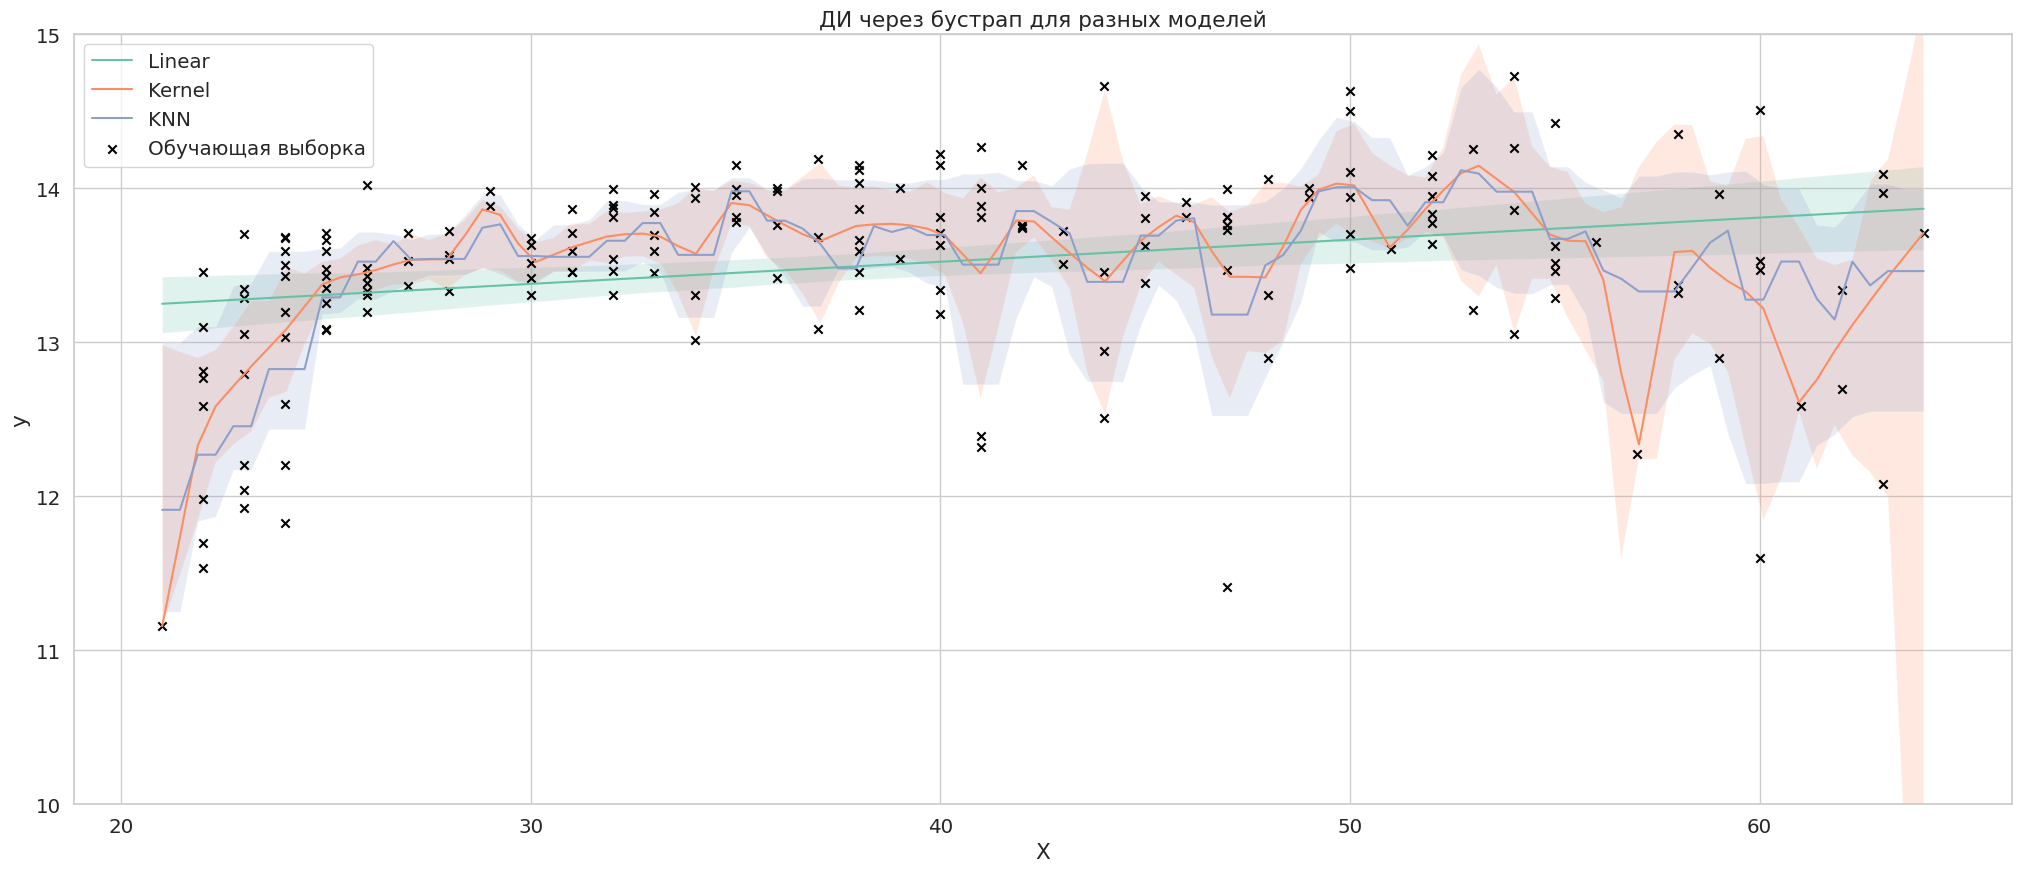

In [26]:
plt.figure(figsize=(25, 10))
for model_name, (y_pred, lower_bound, upper_bound) in bootstrap_results.items():
    plt.plot(X_grid, y_pred, label=f'{model_name}')
    plt.fill_between(X_grid.flatten(),
                     lower_bound.flatten(), upper_bound.flatten(), 
                     alpha=0.2)#, label=f'{model_name} ДИ')

plt.scatter(X_train, y_train, color='black',
            label='Обучающая выборка', marker='x')

plt.xlabel('X')
plt.ylabel('y')
plt.ylim(10, 15)
plt.legend(loc='best')
plt.title('ДИ через бустрап для разных моделей')
plt.show()


Сделайте выводы

**Вывод:**

1) Схожие результаты KNN и Kernel регрессий: обе модели показали близкие прогнозы и доверительные интервалы. Это свидетельствует о том, они хорошо справляются с моделированием сложных нелинейных зависимостей. Однако их интерпретируемость остается ограниченной.
2) Линейная регрессия продемонстрировала узкие доверительные интервалы. Это говорит о низкой вариативности модели и ограниченности её применимости к сложным нелинейным зависимостям. Видно, что модель ошибается: при малых значениях X предсказания отклоняются вниз, а в середине — часть значений выше, а часть ниже линии регрессии. Однако простота и интерпретируемость линейной регрессии остаются её главным преимуществом.
3) Для KNN и Kenel успех напрямую зависит от правильного выбора числа соседей (для KNN) и ширины окна сглаживания (для Kernel). Ошибки в настройке этих параметров могут привести к переобучению или недообучению модели.
4) Бустрап позволяет довольно простым способом оценить ДИ для разных моделей - просто генерируем выборки.

_____
### Задача 1.

В одной известной компании поставлена задача построения нейросети для распознавания котиков и песиков. Для построения такого бинарного классификатора собрана коллекция изображений со сбалансированными классами.

Прошел месяц работы аналитиков и ML-разработчиков, и, наконец-то, нейросеть обучена и готова к использованию. Но руководство хочет убедится, что месяц работы прошел не зря, и построенная нейросеть действительно дает результат.
Как известно, случайный классификатор, выдающий для каждого объекта случайный класс, угадывает ответ правильно с вероятностью $1/2$. И руководству будет достаточно, если модель будет работать лучше. Однако, как их убедить в том, что та же точность 60% действительно отличается от 50%, а не вызвана чистой случайностью? На помощь приходит проверка статистических гипотез &mdash; вы можете проверить статистическую значимость отклонения от базовой точности 50%, и предъявить ее в качестве доказательства.

Сформулируем задачу на математическом языке. Пусть $X_1, ..., X_n \sim Bern(p)$ &mdash; результаты работы модели на тестовой выборке, где $X_i = 1$, если для $i$-го объекта модель правильно определила класс, а $p$ &mdash; неизвестная вероятность такого события.
Мы хотим проверить гипотезу $\mathsf{H}_0\colon p=1/2$ против альтернативы $\mathsf{H}_1\colon p>1/2$. Нулевая гипотеза означает, что построенный классификатор выдает рандомный ответ, а первая &mdash; что чаще все же выдает верный ответ.

На семинаре получено, что $S = \left\{T(x) \geqslant c_\alpha\right\}$, где $T(X) = \sum\limits_{i=1}^n X_i$, является равномерно наиболее мощным критерием для проверки этих гипотез.
Чему при этом равно $c_\alpha$? Учтите, что распределение дискретное, и строгий/нестрогий знак имеет значение.

**Заметим, что** 

$T(X) \sim Binom(n, p)$

По утверждению с семинара, требуется такое $c_\alpha$, что для максимального $\alpha_0 \leq \alpha$: 

$P_{\theta_0}(T(X) \geq c_\alpha) =  1 - P_{\theta_0}(T(X) \leq c_\alpha)= \alpha_0 \Rightarrow P_{\theta_0}(T(X) \leq c_\alpha) = 1 - \alpha_0 $

откуда ищем через квантиль ($c_\alpha$ - $1-\alpha$ квантиль $Binom(n, p)$, но с доп проверкой на дискретность):
```
c_alpha0 = sps.binom(n = n, p = theta_0).ppf(1 - alpha)

if 1 - sps.binom(n = n, p = theta_0).cdf(c_alpha0) > alpha:
    c_alpha0 += 1
```

Проверьте, что критерий работает.
Возьмите несколько значений $n$ и реализаций статистики $T(X)$.
В каждом случае найдите значение $c_\alpha$, а также выведите результат процедуры проверки гипотез 0/1 &mdash; отвергается ли $\mathsf{H}_0$ (выводите 1, если отвергается).
Оформите это в виде таблицы, можно через `pandas.DataFrame`.

*Замечание:* Пользуйтесь функциями из `scipy.stats`.

Функция для тестирования

In [5]:
def hypothesis_test(n, T, alpha=0.05, theta_0=0.5):
    """
    Тестирует нулевую гипотезу на основе статистики T,
    равной сумме всех предсказаний
    """
    c_alpha0 = sps.binom(n=n, p = theta_0).ppf(1 - alpha)
    if 1 - sps.binom(n = n, p = theta_0).cdf(c_alpha0) > alpha:
        c_alpha0 += 1
    
    reject = int(T_obs >= c_alpha0)
    
    return c_alpha0, reject

Сами тесты

In [6]:
n_values = [5, 10, 20, 30, 40, 50]
T_values = [0, 5, 15, 25, 35, 45]
alpha = 0.05
results = []

for n, T_obs in zip(n_values, T_values):
    c_alpha, reject_h0 = hypothesis_test(n, T_obs, alpha)
    results.append([n, T_obs, c_alpha, reject_h0])

df_results = pd.DataFrame(results, columns=["n", "T", "c_alpha", "Отвергаем ли H0"])
df_results

,n,T,c_alpha,Отвергаем ли H0
0,5,0,4.0,0
1,10,5,8.0,0
2,20,15,14.0,1
3,30,25,19.0,1
4,40,35,25.0,1
5,50,45,31.0,1


Теперь для некоторых $n$ постройте графики функции мощности критерия при $1/2 < p < 1$ и уровне значимости 0.05. Сравните их.

Мощность выглядит так:

$\beta_s(p) = P_p(X \in S) = P_p(T(X) \geq c_\alpha) =  1 - P_p(T(X) \leq c_\alpha) = 1 - F_p(c_\alpha)$

Где $F_p$ - функция распределения $Binom(n, p)$

Функция мощности

In [18]:
def power_function(n, theta_0=0.5, alpha=0.05,
                   p_values=np.linspace(0.5, 1, 1000)):
    """
    Строит функцию мощности для критерия при различных p > 0.5.
    """

    c_alpha0 = sps.binom(n=n, p = theta_0).ppf(1 - alpha)
    if 1 - sps.binom(n = n, p = theta_0).cdf(c_alpha0) > alpha:
        c_alpha0 += 1

    power = [1 - sps.binom(n=n, p=p).cdf(c_alpha0) for p in p_values]

    return p_values, power

И само построение

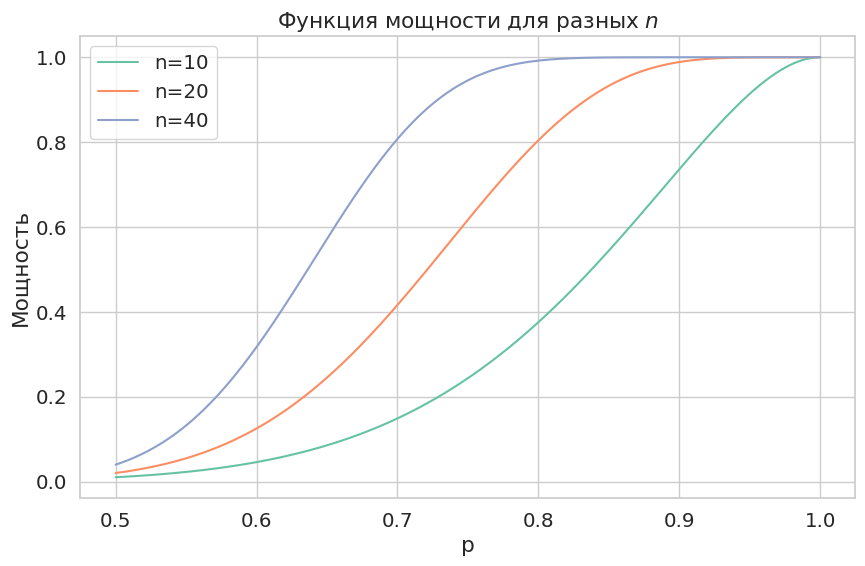

In [20]:
plt.figure(figsize=(10, 6))

for n in [10, 20, 40]:
    p_values, power = power_function(n)
    plt.plot(p_values, power, label=f"n={n}")

plt.xlabel("p")
plt.ylabel("Мощность")
plt.title(r"Функция мощности для разных $n$")
plt.legend()
plt.grid(True)
plt.show()

**Вывод:** 

1) С помощью статистических гипотез мы можем сделать статистически значимую проверку того, что есть улучшение продукта

2) С ростом размера выборки $n$ растет и мощность, равномерно по всем значениям $p$.

3) Чем больше значение $p$, тем выше и мощность - что логично, в таком случае проще обнаружить статистические различия

4) Рост мощности из-за роста $n$ неравномерный по $p$

_____
### Задача 2.

На практике часто рассматривают асимптотические критерии, например, критерий Вальда. Такие критерии контролируют вероятность ошибки I рода на уровне $\alpha$ только в пределе, однако для небольших выборок она может сильно отличаться от $\alpha$, причем не редко в большую сторону. Поэтому для таких критериев возникает необходимость в вычислении значения вероятности ошибки I рода при конечной выборке.

Зачастую посчитать точное значение вероятности ошибки I рода довольно сложно, поэтому вместо него вычисляют оценку с помощью семплирования по методу Монте-Карло.

Пусть гипотеза $\mathsf{H}_0$ простая, то есть $\mathsf{H}_0\colon \mathsf{P} = \mathsf{P}_0$. Для ее проверки по конечной выборке $X_1, ..., X_n$ используется критерий $S$. **Опишите схему оценки вероятности ошибки I рода** критерия $S$ методом Монте-Карло.

Ошибка I это отвержение $H_0$, при условии, что она верна

Поэтому нам достаточно:
1) $M$ раз сгенерировать выборки размера $n$ из распределения $\mathsf{P}_0$
2) Для каждой выборки проверить $X \in S$
3) Пусть $M'$ - число выборок, что $X \in S$ (сколько раз мы отвергли $H_0$)
4) Тогда оценка вероятности ошибки первого рода:
   $$\hat{\mathsf{P}}(I_S) = \frac{M'}{M}$$

Если гипотеза $\mathsf{H}_0$ сложная, то есть $\mathsf{H}_0\colon \mathsf{P} \in \mathscr{P}_0$, то можно повторить такую процедуру несколько раз для разных $\mathsf{P} \in \mathscr{P}_0$.

Рассмотрим альтернативную гипотезу $\mathsf{H}_1\colon \mathsf{P} \in \mathscr{P}_1$. **Опишите схему оценки мощности** критерия $S$ методом Монте-Карло.

Мощность $\beta_s(p) = P_p(X \in S)$ (зависит от распределения $p \in \mathscr{P}_1$)

Поэтому нам достаточно:
1) $M$ раз сгенерировать выборки размера $n$ из распределения $p$
2) Для каждой выборки проверить $X \in S$
3) Пусть $M'$ - число выборок, что $X \in S$ (сколько раз мы отвергли $H_0$)
4) Тогда оценка мощности:
   $$\hat{\beta_s}(p) = \frac{M'}{M}$$

Пусть $X_1, ..., X_n$ &mdash; выборка из пуассоновского распределения с параметром $\theta$. Рассмотрим гипотезы $\mathsf{H}_0\colon \theta = 1\ \ vs.\ \ \mathsf{H}_1\colon \theta \not= 1$ и критерий Вальда для их проверки.

**1.** **Оцените вероятности ошибки I рода** критерия для размеров выборки $1 \leqslant n \leqslant 50$ и визуализируйте полученную зависимость.

Матожидание и дисперсия Пуассоновского распределения: $\theta$

Значит, $\hat{\theta} = \overline X$ - а.н.о. $\theta$ с а.д. $\theta$ (из ЦПТ и леммы Слуцкого):

$$W(X) = \sqrt{n} \frac{\hat \theta - \theta_0}{\sqrt{\theta_0}} \rightarrow^{d_{\theta_0}} N(0, 1) $$

Поэтому в нашем случае критерий выглядит так:

$$S = \{X~\big|~|W(X)| \geq Z_{1 - \frac{\alpha}{2}} \}$$

где $Z_k$ - $k$-квантиль $N(0, 1)$

Функция подсчета ошибок 1 рода:

In [3]:
def estimate_type_i_error_rates(num_simulations, n_values, theta_0, alpha):
    Z_alpha = sps.norm.ppf(1 - alpha / 2)

    all_samples = np.random.poisson(theta_0, (num_simulations, max(n_values)))

    type_i_error_rates = np.zeros(len(n_values))

    for i, n in enumerate(n_values):
        means = np.mean(all_samples[:, :n], axis=1)
        W = np.sqrt(n) * (means - theta_0) / np.sqrt(theta_0)
        type_i_error_rates[i] = np.mean(np.abs(W) >= Z_alpha)

    return type_i_error_rates

Теперь подсчет значений и визуализация:

В более узких пределах

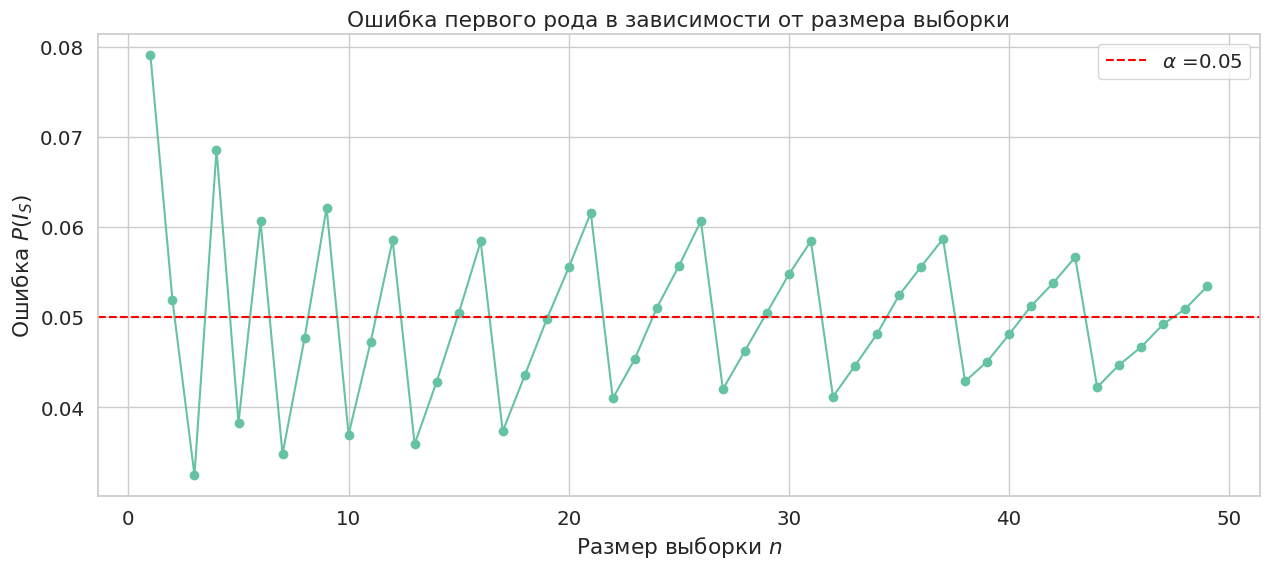

In [4]:
theta_0 = 1 
alpha = 0.05
n_values = np.arange(1, 50)
num_simulations = 100000

type_i_errors = estimate_type_i_error_rates(num_simulations, n_values, theta_0, alpha)

plt.figure(figsize=(15, 6))
plt.plot(n_values, type_i_errors, marker='o')
plt.axhline(y=alpha, color='r', linestyle='--', label=r'$\alpha$ =0.05')
#plt.axvline(x=10, color='g', linestyle='--', label='n = 10')
plt.title('Ошибка первого рода в зависимости от размера выборки')
plt.xlabel(r'Размер выборки $n$')
plt.ylabel(r'Ошибка $P(I_S)$')
plt.legend()
plt.grid(True)
plt.show()

В более широких пределах

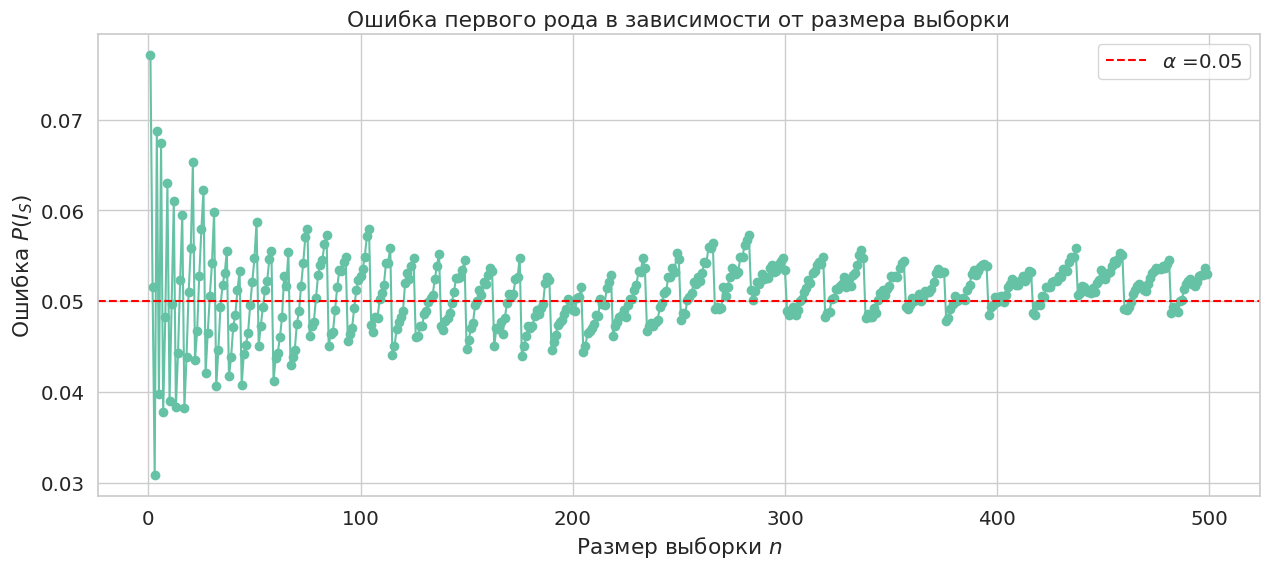

In [5]:
theta_0 = 1 
alpha = 0.05
n_values = np.arange(1, 500)
num_simulations = 10000

type_i_errors = estimate_type_i_error_rates(num_simulations, n_values, theta_0, alpha)

plt.figure(figsize=(15, 6))
plt.plot(n_values, type_i_errors, marker='o')
plt.axhline(y=alpha, color='r', linestyle='--', label=r'$\alpha$ =0.05')
#plt.axvline(x=10, color='g', linestyle='--', label='n = 10')
plt.title('Ошибка первого рода в зависимости от размера выборки')
plt.xlabel(r'Размер выборки $n$')
plt.ylabel(r'Ошибка $P(I_S)$')
plt.legend()
plt.grid(True)
plt.show()

**Вывод:**

Как видно, с ростом выборки ошибка приближается к значению $\alpha$. Однако она убывает нелинейно и имеет случайный характер. В целом, можно брать выборки порядка 50

**2.** Для значений $n \in \{5, 15, 50\}$ **оцените функцию мощности критерия** для значений $\theta \in (0, 5)$ по сетке с шагом 0.01 по методу Монте-Карло. Визуализируйте полученные зависимости.

Функция оценки мощности

In [8]:
def estimate_power(num_simulations, n_values, theta_values, alpha):
    Z_alpha = sps.norm.ppf(1 - alpha / 2)

    all_samples = np.random.poisson(np.array(theta_values)[:, None, None],
                                    (len(theta_values), num_simulations,
                                     max(n_values)))

    power_estimates = np.zeros((len(theta_values), len(n_values)))

    for i, n in enumerate(n_values):
        means = np.mean(all_samples[:, :, :n], axis=2)
        W = np.sqrt(n) * (means - 1) / np.sqrt(1)
        
        power_estimates[:, i] = np.mean(np.abs(W) >= Z_alpha, axis=1)

    return power_estimates

Сам подсчет

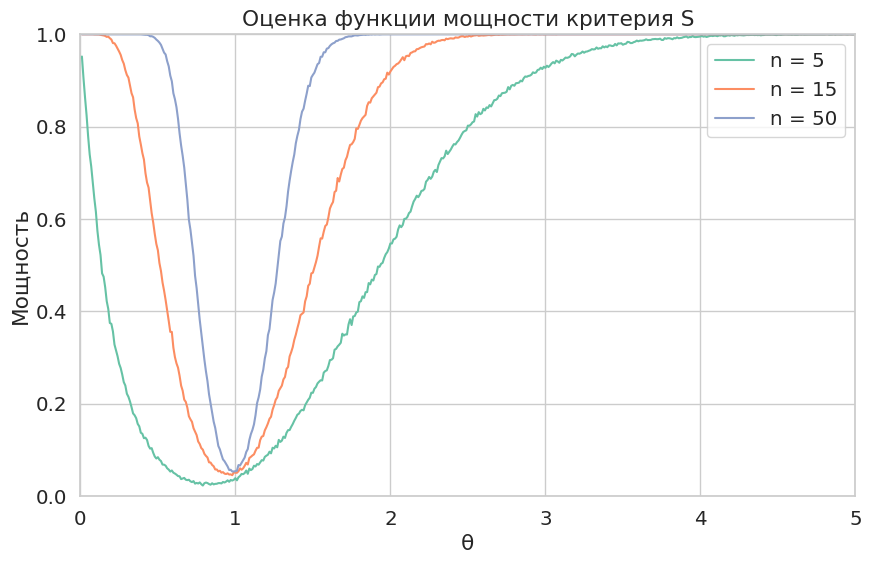

In [11]:
num_simulations = 10000
n_values = [5, 15, 50]
theta_values = np.arange(0.01, 5.01, 0.01)

power_estimates = estimate_power(num_simulations, n_values, theta_values, alpha=0.05)

plt.figure(figsize=(15, 6))
for i, n in enumerate(n_values):
    plt.plot(theta_values, power_estimates[:, i], label=f'n = {n}')

plt.title('Оценка функции мощности критерия S')
plt.xlabel('θ')
plt.ylabel('Мощность')
plt.legend()
plt.grid(True)
plt.xlim(0, 5)
plt.ylim(0, 1)
plt.show()

**Вывод:**

1) Как и ожидалось, график имеет вид выгнутого колокола с минимумом около 1. Если распределение близко к базовому $P_0$, то опровергнуть $H_0$ сложнее; чем дальше $\theta$ от $1$, тем выше мощность
3) Чем больше выборка, тем больше мощность
4) График не симметричный, центр колокола тоже не всегда в 1 - за счет того, что сходимость только ассимптотическая

**3.** Пусть $n=50$. **Сравните мощности критериев**, соответствующих двусторонней, левосторонней и правосторонней альтернативам.

Функция запуска тестов

In [26]:
def estimate_power_comparison(num_simulations, n, theta_values, alpha):
    Z_alpha_two_tailed = sps.norm.ppf(1 - alpha/2)
    Z_alpha_left_tailed = sps.norm.ppf(alpha)
    Z_alpha_right_tailed = sps.norm.ppf(1 - alpha)

    all_samples = np.random.poisson(theta_values[:, np.newaxis, np.newaxis], 
                                     (len(theta_values), num_simulations, n))
    
    means = np.mean(all_samples, axis=2)
    
    W = np.sqrt(n) * (means - 1) / np.sqrt(1)

    power_two_tailed = np.mean(np.abs(W) >= Z_alpha_two_tailed, axis=1)
    power_left_tailed = np.mean(W <= Z_alpha_left_tailed, axis=1)
    power_right_tailed = np.mean(W >= Z_alpha_right_tailed, axis=1)

    return power_two_tailed, power_left_tailed, power_right_tailed

Запуск кода

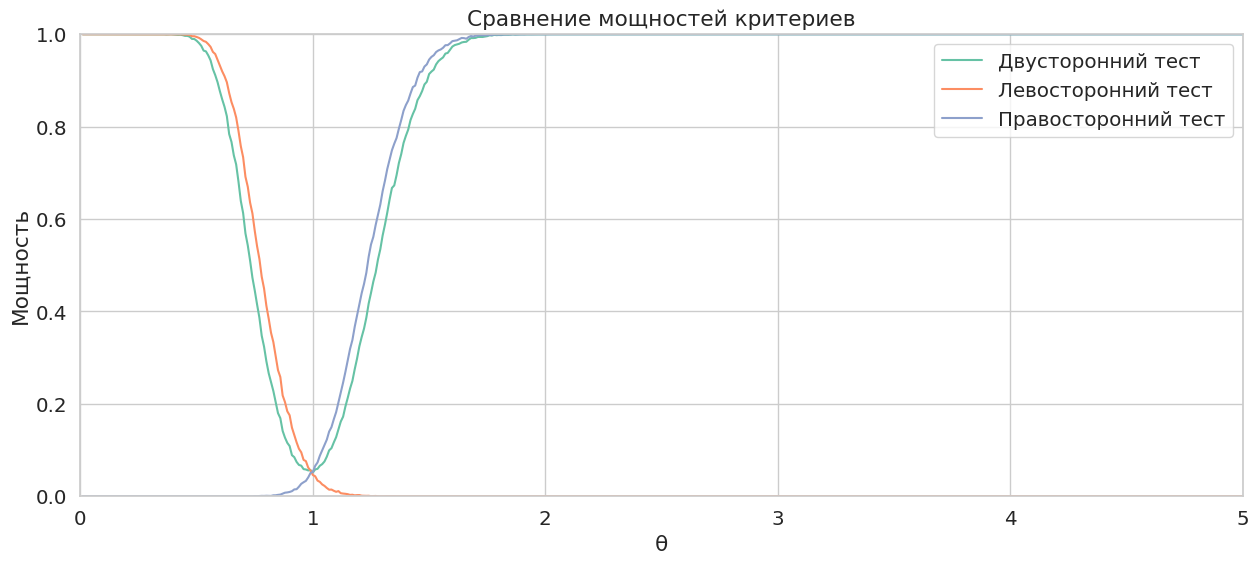

In [28]:
num_simulations = 10000
n = 50
theta_values = np.arange(0.01, 5.01, 0.01)

two, left, right = estimate_power_comparison(num_simulations,
                                             n, theta_values, alpha=0.05)

plt.figure(figsize=(15, 6))
plt.plot(theta_values, two, label='Двусторонний тест')
plt.plot(theta_values, left, label='Левосторонний тест')
plt.plot(theta_values, right, label='Правосторонний тест')
plt.axhline(0.05, color='gray', linestyle='--', label=r'$\alpha$ = 0.05')

plt.title('Сравнение мощностей критериев')
plt.xlabel('θ')
plt.ylabel('Мощность')
plt.legend()
plt.grid(True)
plt.xlim(0, 5)
plt.ylim(0, 1)
plt.show()

**Вывод:**

Односторонние тесты мощнее если $\theta$ отклонено в соответствущую сторону и мощнее более универсального двустороннего теста. Однако двусторонний тест очевидно мощнее если отклонение происходит в противоположную сторону.

Таким образом, если мы знаем сторону, в которую будет отклонение - мы можем дать более точный критерий, что логично. Если не знаем - то критерий будет менее точным.

**Вопрос на подумать.** Сколько семплирований в методе Монте-Карло нужно сделать, чтобы оценить вероятности ошибки I рода с точностью до 0.001? Иначе говоря, значения (0.049, 0.051) можно принять за 0.05.

Критерий проходим с вероятностью $\beta$ (искомая вероятность ошибки первого рода) - факт прохождения распределен как $Be(\beta)$ (1 если прошли, 0 если не прошли), а их сумма как $binom(n, \beta)$.

Соответственно, мы хотим оценить $\beta$ с точностью 0.001. Можно использовать точный ДИ для бернуллевского распределения шириной 0.001 (и уровня доверия, например, $\alpha$) (задаем ширину -> можно вытащить $n$). Из вида интервала мы знаем что он убывает как $\frac{1}{\sqrt n}$



_____
### Задача 3.

Пусть $X_1, ..., X_n$ &mdash; выборка из распределения $\Gamma(\theta, \beta)$. Рассмотрим основную гипотезу $\mathsf{H}_0\colon \theta = 2$.

**1.** Пусть $\beta$ неизвестно. Для размеров выборки $n \in \{5, 15, 30, 50, 100\}$ **оцените вероятности ошибки I рода** критерия Вальда для двусторонней альтернативы в зависимости от истинных значений $\beta$. Визуализируйте полученные зависимости.

Из ST2:

Ассимптотическая оценка $\theta$:

$$\hat \theta = \frac{\overline{X}}{\overline{X^2} - \overline{X}^2}$$

С ассимптотической дисперсией

$$2 \left( \frac{\overline{X}}{\overline{X^2} - \overline{X}^2} \right)^2 + \frac{3}{\overline{X^2} - \overline{X}^2}$$

Откуда строим статистику

$$W(X) = \sqrt{n} \frac{\hat \theta - \theta_0}{\sqrt{\theta_0}} \rightarrow^{d_{\theta_0}} N(0, 1) $$

Поэтому в нашем случае двусторонний критерий выглядит так:

$$S = \{X~\big|~|W(X)| \geq Z_{1 - \frac{\alpha}{2}} \}$$

Функция подсчета:

In [3]:
def estimate_type_i_error_rates(num_simulations, n_values,
                                beta_values, theta_0=2, alpha=0.05):
    Z_alpha = sps.norm.ppf(1 - alpha / 2)
    
    type_i_error_rates = np.zeros((len(n_values), len(beta_values)))

    all_samples = np.random.gamma(shape=np.array(beta_values)[:, None, None],
                                   scale=1/theta_0,
                                   size=(len(beta_values),
                                         num_simulations, max(n_values)))

    for i, n in enumerate(n_values):
        means = np.mean(all_samples[:, :, :n], axis=2)
        means_squared = np.mean(all_samples[:, :, :n]**2, axis=2)

        hat_theta = means / (means_squared - means**2)

        var_hat_theta = 2 * hat_theta**2 + 3 / (means_squared - means**2)

        W = np.sqrt(n) * (hat_theta - theta_0) / np.sqrt(var_hat_theta)

        type_i_error_rates[i] = np.mean(np.abs(W) >= Z_alpha, axis=1)

    return type_i_error_rates

Сам подсчет:

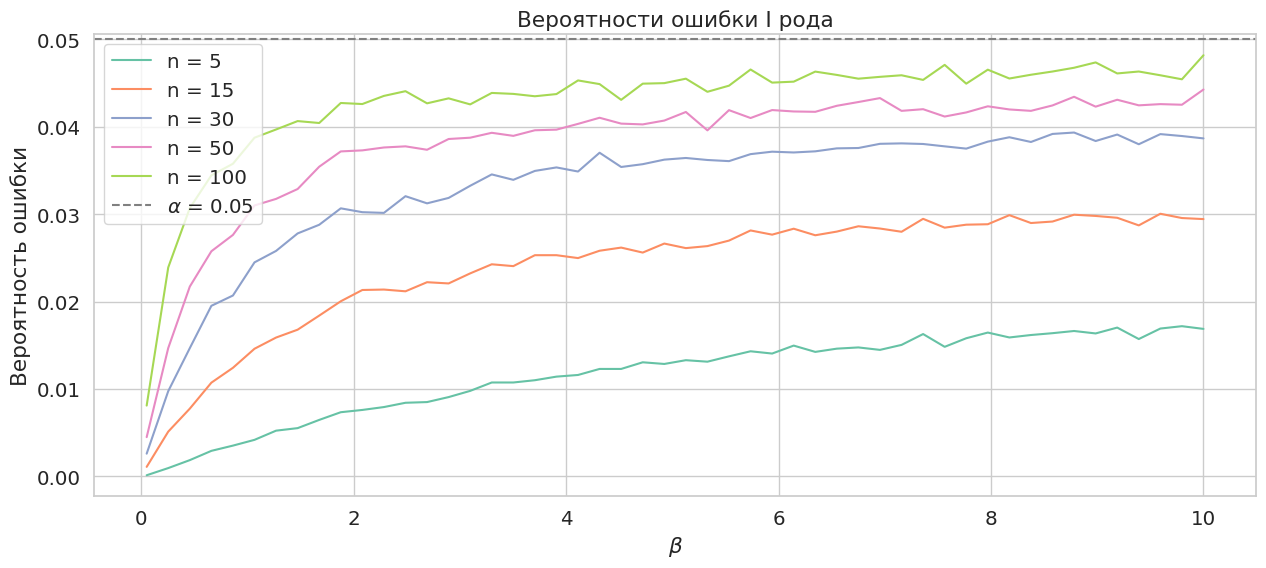

In [5]:
num_simulations = 100000
n_values = [5, 15, 30, 50, 100]
beta_values = np.linspace(0.05, 10, 50) 

type_i_error_rates = estimate_type_i_error_rates(num_simulations, n_values, beta_values)

plt.figure(figsize=(15, 6))
for i, n in enumerate(n_values):
    plt.plot(beta_values, type_i_error_rates[i], label=f'n = {n}')

plt.axhline(0.05, color='gray', linestyle='--', label=r'$\alpha$ = 0.05')
plt.title('Вероятности ошибки I рода')
plt.xlabel(r'$\beta$')
plt.ylabel('Вероятность ошибки')
plt.legend()
plt.grid(True)
plt.show()

**Вывод:**

С ростом $n$ растет и ошибка - критерий усиляется и начинает работать. Так же растет ошибка и с ростом $\beta$ (для всех $n$), а при маленьком $\beta$ становится меньше - приближается к нулю. Что логично:

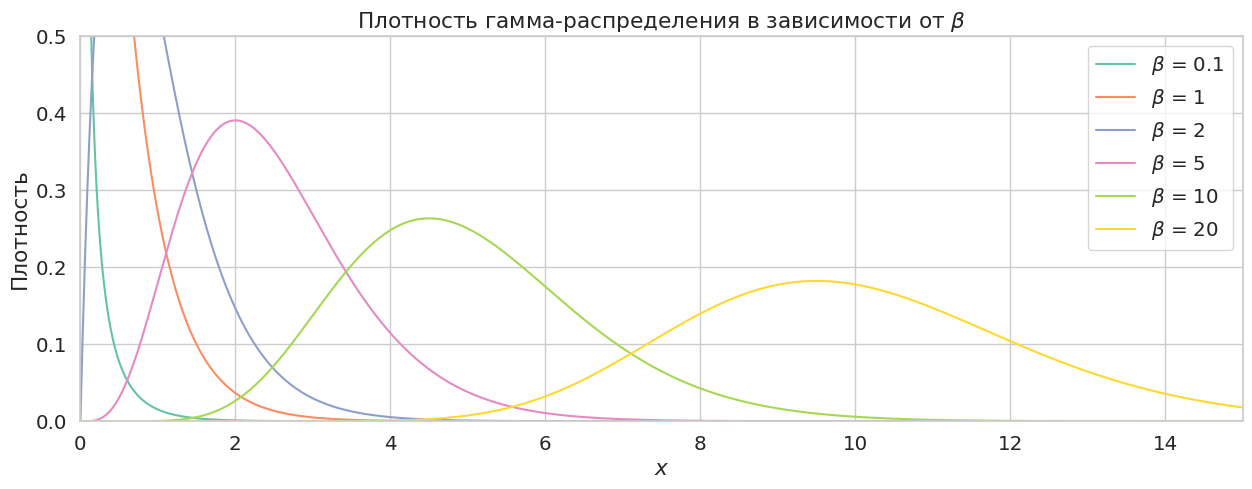

In [10]:
beta_values = [0.1, 1, 2, 5, 10, 20]
theta = 2
x = np.linspace(0, 15, 1000) 

plt.figure(figsize=(15, 5))
for beta in beta_values:
    pdf = sps.gamma.pdf(x, a=beta, scale=1/theta)
    plt.plot(x, pdf, label=rf'$\beta$ = {beta}')

plt.title(r'Плотность гамма-распределения в зависимости от $\beta$')
plt.xlabel(r'$x$')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.xlim(0, 15)
plt.ylim(0, 0.5)

plt.show()

Потому что при маленьких $\beta$ все значения сосредоточены внутри нуля и маленькая дисперсия, соответственно ошибиться сложно. Ограничение сверху вероятности ошибки первого рода в 0.05 должно ограничивать по всем $\beta$, а значит для маленьких $\beta$ он будет покрывать с запасом.

**2.** Пусть $\beta$ известно. **Сравните по мощности** РНМК и критерий Вальда (*для известной $\beta$*) для левосторонней и правосторонней альтернатив, а также двусторонней альтернативы для критерия Вальда.

Из ST2:

Ассимптотическая оценка $\theta$:

$$\hat \theta = \frac{\beta}{\overline{X}}$$

С ассимптотической дисперсией

$$\sigma^2 = \frac{\beta}{\overline{X}^2}$$

Откуда строим статистику

$$W(X) = \sqrt{n} \frac{\hat \theta - \theta_0}{\sqrt{\theta_0}} \rightarrow^{d_{\theta_0}} N(0, 1) $$

Двусторонний:

$$S = \{X~\big|~|W(X)| \geq Z_{1 - \frac{\alpha}{2}} \}$$

Левосторонний:

$$S = \{X~\big|~W(X) \leq Z_{\alpha} \}$$

Правосторонний:

$$S = \{X~\big|~W(X) \geq Z_{1 - \alpha} \}$$

Из теории ST8:

По статистике $T(X) = \sum_{i=1}^n X_i$:

Левый РМНК:

$$S = \{X~\big|~ T(X) \geq c_{1-\alpha}\}$$

Правый РМНК

$$S = \{X~\big|~ T(X) \leq c_\alpha\}$$

где $c_k$- $k$ квантиль $\text{Gamma}(a=n \beta, scale=\frac{1}{\theta_0})$

Функция подсчета 

In [95]:
def estimate_power(num_simulations, n, theta_values, beta, alpha):
    Z_alpha_two = sps.norm.ppf(1 - alpha / 2)
    Z_alpha_left = sps.norm.ppf(alpha)
    Z_alpha_right = sps.norm.ppf(1 - alpha)

    all_samples = np.random.gamma(
        shape=beta, 
        scale=1 / theta_values[:, np.newaxis, np.newaxis], 
        size=(len(theta_values), num_simulations, n)
    )

    means = np.mean(all_samples, axis=2)

    hat_theta = beta / means
    var_hat_theta = beta / means**2

    W = np.sqrt(n) * (hat_theta - 2) / np.sqrt(var_hat_theta)

    two_wald = np.mean(np.abs(W) >= Z_alpha_two, axis=1)
    left_wald = np.mean(W <= Z_alpha_left, axis=1)
    right_wald = np.mean(W >= Z_alpha_right, axis=1)

    c_left = sps.gamma.ppf(1 - alpha, a=n * beta, scale=1 / 2)
    c_right = sps.gamma.ppf(alpha, a=n * beta, scale=1 / 2)

    sums = np.sum(all_samples, axis=2)
    rmnk_left = np.mean(sums >= c_left, axis=1)
    rmnk_right = np.mean(sums <= c_right, axis=1)

    return two_wald, left_wald, right_wald, rmnk_left, rmnk_right

И сам подсчет

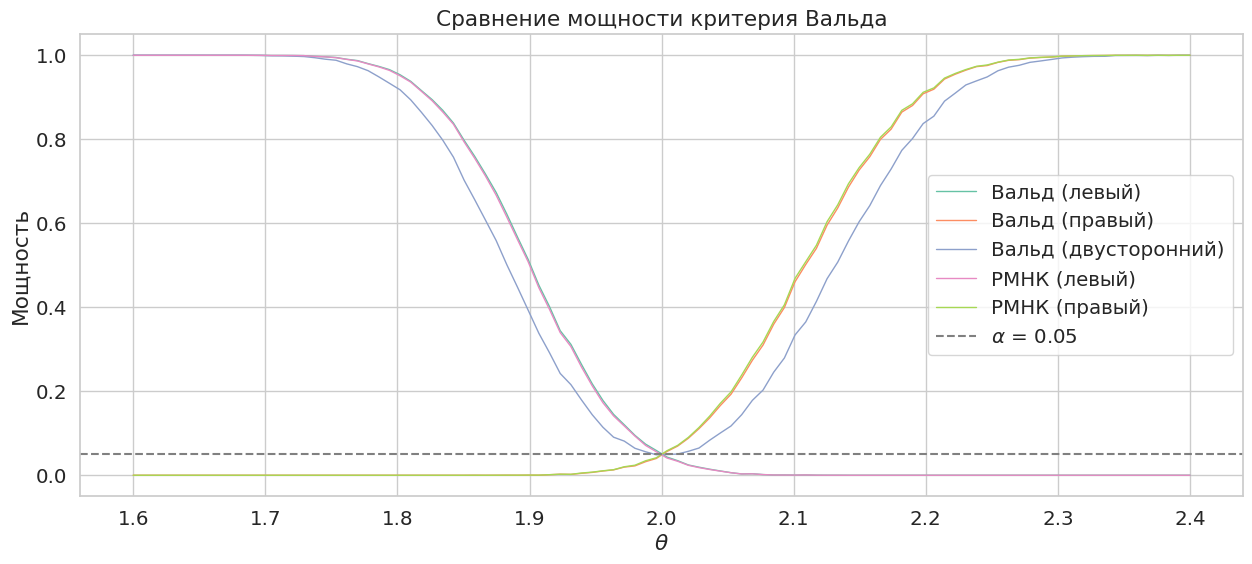

In [109]:
num_simulations = 10000
n = 500
theta_values = np.linspace(1.6, 2.4, 100)
beta = 2
alpha = 0.05

two_w, left_w, right_w, left_rmnk, right_rmnk = estimate_power(num_simulations,
                                                    n, theta_values,
                                                    beta, alpha)
plt.figure(figsize=(15, 6))
plt.plot(theta_values, left_w, label='Вальд (левый)', linewidth=1)
plt.plot(theta_values, right_w, label='Вальд (правый)', linewidth=1)
plt.plot(theta_values, two_w, label='Вальд (двусторонний)', linewidth=1)
plt.plot(theta_values, left_rmnk, label='РМНК (левый)', linewidth=1)
plt.plot(theta_values, right_rmnk, label='РМНК (правый)', linewidth=1)
plt.axhline(0.05, color='gray', linestyle='--', label=r'$\alpha$ = 0.05')

plt.title('Сравнение мощности критерия Вальда')
plt.xlabel(r'$\theta$')
plt.ylabel('Мощность')
plt.legend()
plt.grid(True)
plt.show()

**Вывод:** 

Односторонние тесты мощнее если $\theta$ отклонено в соответствущую сторону и мощнее более универсального двустороннего теста. Однако двусторонний тест очевидно мощнее если отклонение происходит в противоположную сторону.

РМНК и Вальд при достаточно большом $n$ (на этом графике 500) уже почти совпадают